In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
from google.colab import files
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
# data containing defect images with segmentation mask
defect_class_mask_df = pd.read_csv('/content/drive/My Drive/SM/train.csv')

In [ ]:
# data containing defective and non defective images
all_images_df = pd.read_csv('/content/drive/My Drive/SM/defect_and_no_defect.csv')

In [ ]:
defect_class_mask_df

,ImageId,ClassId,EncodedPixels
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...
...,...,...,...
5743,c12842f5e.jpg,3,88 23 342 29 596 34 850 39 1105 44 1361 46 161...
5744,2222a03b3.jpg,3,63332 4 63587 11 63841 20 64096 27 64351 35 64...
5745,b43ea2c01.jpg,1,185024 7 185279 11 185535 12 185790 13 186045 ...
5746,1bc37a6f4.jpg,3,303867 1 304122 3 304376 6 304613 3 304630 9 3...


There are 5748 defect images in dataset

In [ ]:
all_images_df

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


class labels->
0 - non-defect images,
1,2,3,4 - defect images

Visualize Data

In [ ]:
defect_class_mask_df['mask'] = defect_class_mask_df['ClassId'].map(lambda x: 1)

In [ ]:
defect_class_mask_df.head(50)

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1
5,17d02873a.jpg,3,254980 43 255236 127 255492 211 255748 253 256...,1
6,47b5ab1bd.jpg,3,128976 8 129230 12 129484 16 129739 23 129995 ...,1
7,a6ecee828.jpg,3,179011 27 179126 73 179259 39 179375 80 179497...,1
8,11aaf18e2.jpg,3,303235 2 303489 7 303743 9 303997 11 304181 2 ...,1
9,cdf669a1f.jpg,4,310246 11 310499 25 310753 28 311007 31 311262...,1


In [ ]:
defect_type = defect_class_mask_df.groupby(['ImageId'])['mask'].sum()

In [ ]:
defect_type

,mask
ImageId,
0002cc93b.jpg,1
0007a71bf.jpg,1
000a4bcdd.jpg,1
000f6bf48.jpg,1
0014fce06.jpg,1
...,...
ffcf72ecf.jpg,1
fff02e9c5.jpg,1
fffe98443.jpg,1


In [ ]:
defect_type.value_counts()

,count
mask,
1,5201
2,272
3,1


Text(0.5, 1.0, 'Number of defects in image')

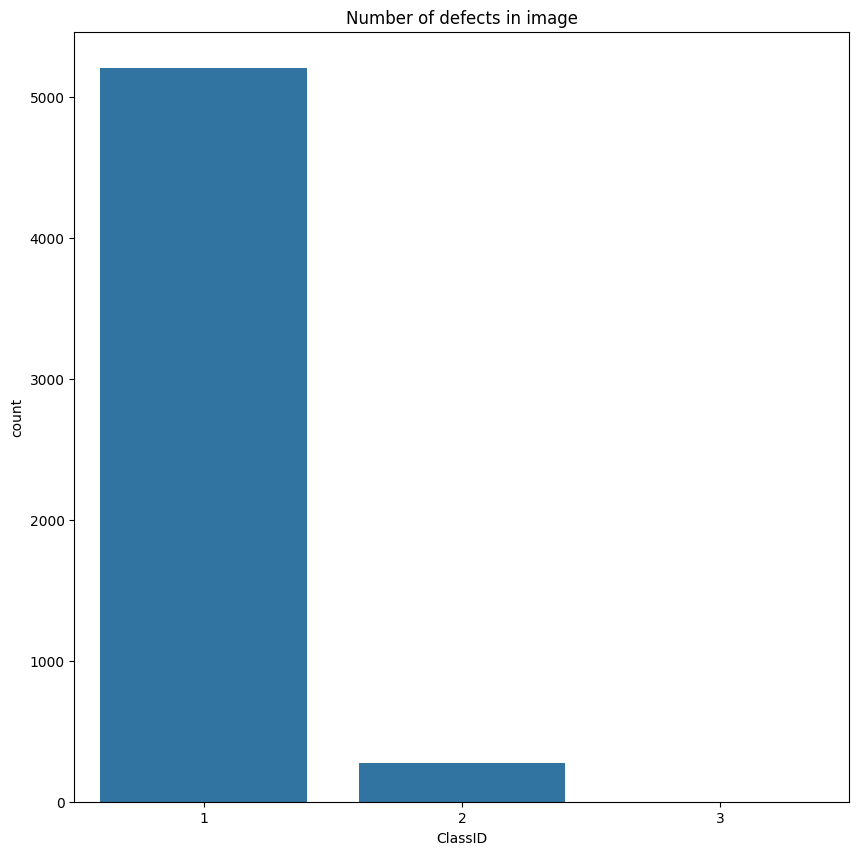

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(x = defect_type.value_counts().index, y = defect_type.value_counts() )
plt.xlabel('ClassID')
plt.title('Number of defects in image')

In [ ]:
defect_class_mask_df.shape

(5748, 4)

In [ ]:
all_images_df.shape

(12997, 2)

In [ ]:
# Let's count defective and non defective images
all_images_df.label.value_counts()

,count
label,
1,7095
0,5902


Text(0.5, 1.0, 'Defect and non-defect images')

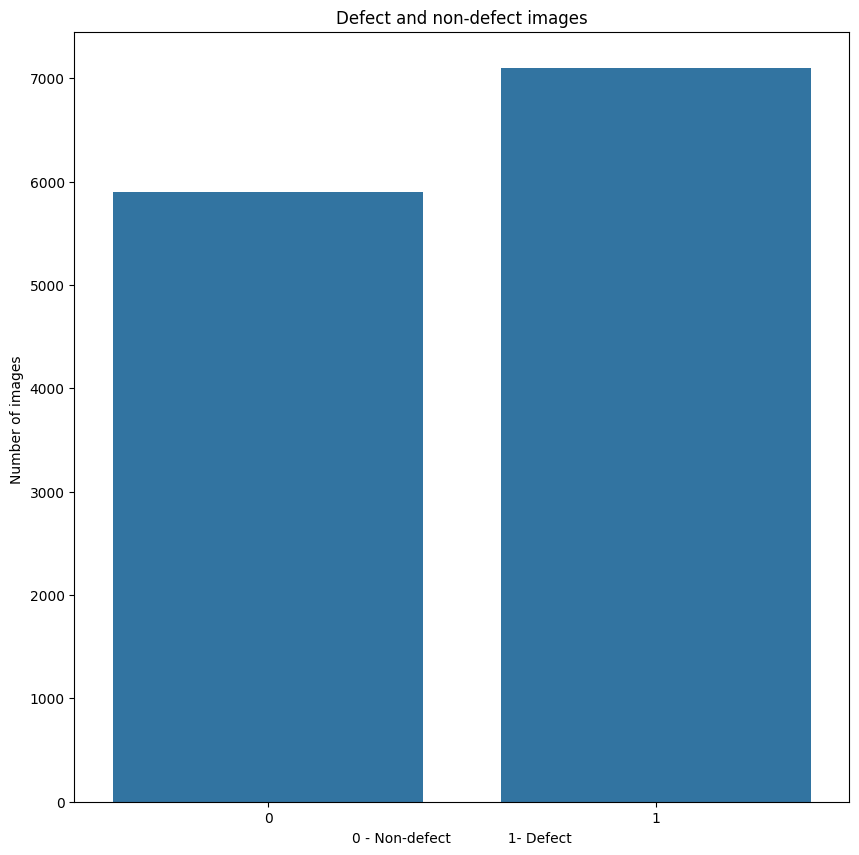

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(x = all_images_df.label.value_counts().index, y = all_images_df.label.value_counts() )
plt.ylabel('Number of images ')
plt.xlabel('0 - Non-defect             1- Defect')
plt.title('Defect and non-defect images')

In [ ]:
import os
import io
from skimage import io
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
train_dir = '/content/drive/My Drive/SM/train_images/'

print(train_dir)

/content/drive/My Drive/SM/train_images/


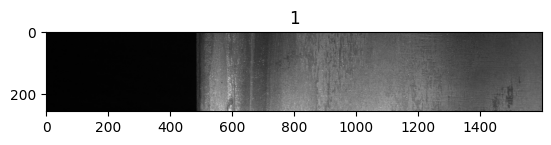

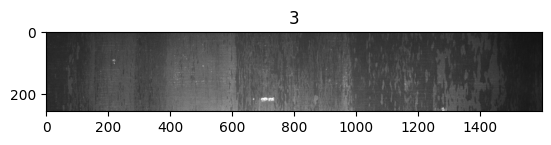

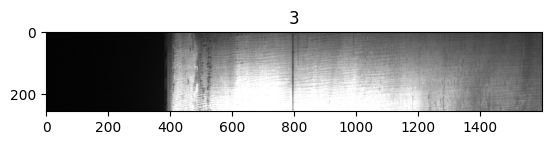

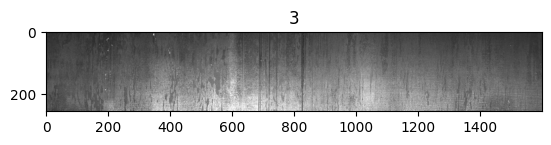

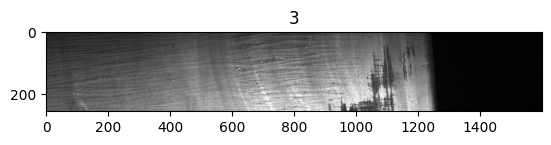

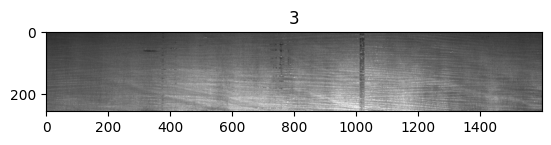

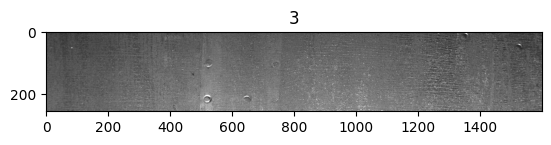

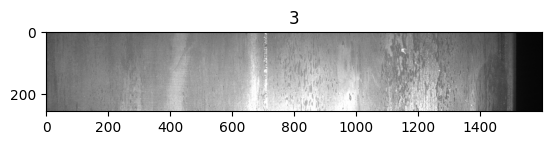

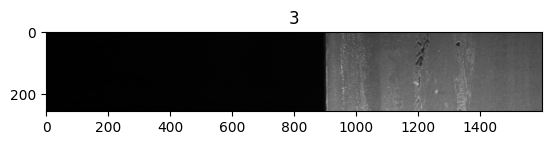

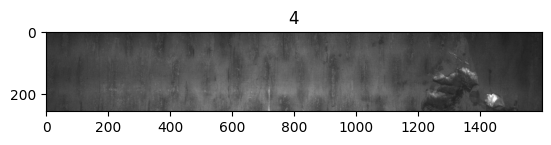

In [ ]:
# Visualize images with defects along with their corresponding labels
# Images are 256 x 1600
!pip install imageio
import os
import io
from skimage import io
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
train_dir = '/content/drive/My Drive/SM/train_images/'

for i in range(10):
  # Specify the path to the images given their image ID
  image_id = defect_class_mask_df.ImageId[i]
  img_path = os.path.join(train_dir, image_id)

  # Check if the file exists
  if os.path.exists(img_path):
    img = io.imread(img_path)
    plt.figure()
    plt.title(defect_class_mask_df.ClassId[i])
    plt.imshow(img)
  else:
    print(f"Image not found: {img_path}")


In [ ]:
#convert between Run-Length Encoded (RLE)
%cd /content/drive/My Drive/SM
from utilities import rle2mask , mask2rle

train_dir = '/content/drive/My Drive/SM/train_images/'

'''- They navigate to the project's root directory.
- They load custom utility functions for dealing with mask data.
- They define the directory where your training images are stored.

SyntaxError: incomplete input (<ipython-input-12-d29cc2546fe7>, line 7)

In [ ]:
defect_class_mask_df

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1
...,...,...,...,...
5743,c12842f5e.jpg,3,88 23 342 29 596 34 850 39 1105 44 1361 46 161...,1
5744,2222a03b3.jpg,3,63332 4 63587 11 63841 20 64096 27 64351 35 64...,1
5745,b43ea2c01.jpg,1,185024 7 185279 11 185535 12 185790 13 186045 ...,1
5746,1bc37a6f4.jpg,3,303867 1 304122 3 304376 6 304613 3 304630 9 3...,1


In [ ]:
# Let's try to use the rle2mask on a sample image
image_index = 20 #20 30
mask = rle2mask(defect_class_mask_df.EncodedPixels[image_index], img.shape[0], img.shape[1])
mask.shape

(256, 1600)

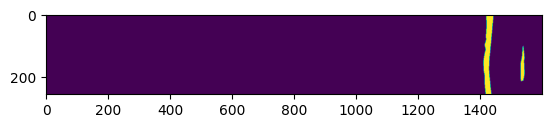

In [ ]:
# Let's show the mask
plt.imshow(mask)

(256, 1600, 3)

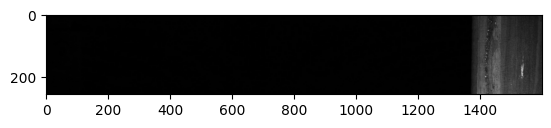

In [ ]:
img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[image_index]))
plt.imshow(img)
img.shape

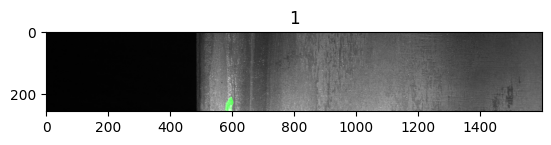

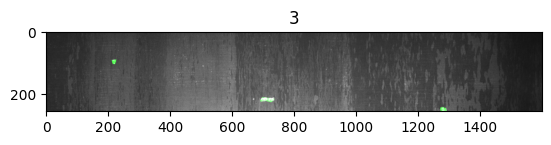

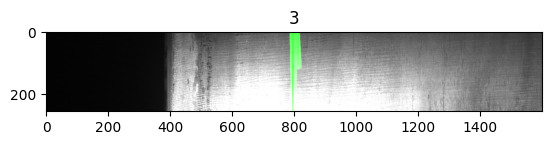

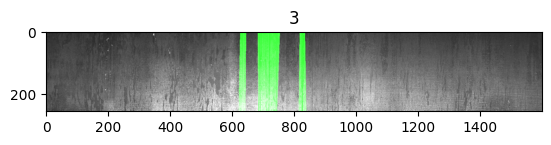

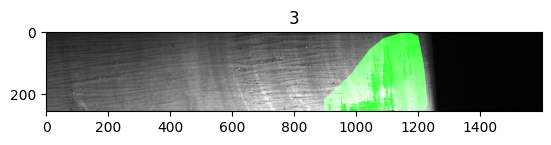

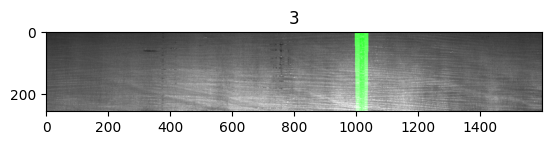

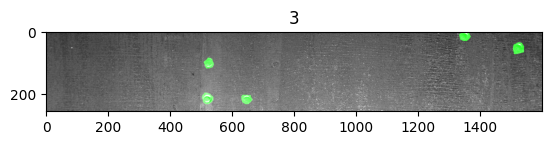

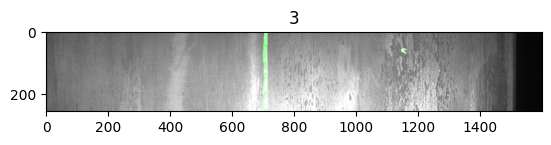

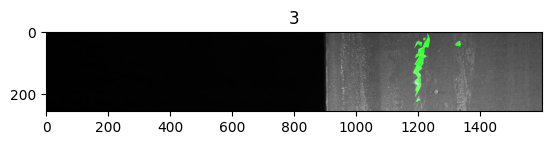

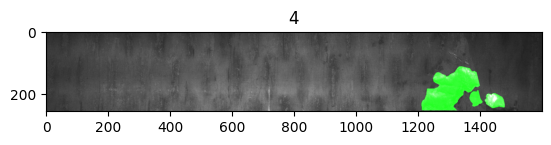

In [ ]:
for i in range(10):

  # Read the images using opencv and converting to rgb format
  img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Get the mask for the image from rle
  mask = rle2mask(defect_class_mask_df.EncodedPixels[i], img.shape[0], img.shape[1])

  # Let's color the pixels with values = 1
  img[mask == 1,1] = 255
  plt.figure()
  plt.imshow(img)
  plt.title(defect_class_mask_df.ClassId[i])

###BUILD AND TRAIN A DEEP LEARNING MODEL (ResNet50) TO DETECT WHETHER A DEFECT IS PRESENT IN AN IMAGE OR NOT

In [ ]:
all_images_df

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


In [ ]:
# split the data (defective and non defective) into training and testing
from sklearn.model_selection import train_test_split
train, test = train_test_split(all_images_df, test_size=0.15)

85% for training, 15% for testing

In [ ]:
train.shape

(11047, 2)

In [ ]:
test.shape

(1950, 2)

In [ ]:
train_dir = '/content/drive/My Drive/SM/train_images/'


In [ ]:
# create a image generator for the training and validation dataset
# we will divide the data to training, validation and testing
# Training = 9390
# validation = 1657
# testing = 1950
!pip install keras_preprocessing
from keras_preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

train_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = train_dir,
x_col = "ImageID",
y_col = "label",
subset = "training",
batch_size = 16,
shuffle = True,
class_mode = "other",
target_size = (256, 256))


valid_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = train_dir,
x_col = "ImageID",
y_col = "label",
subset = "validation",
batch_size = 16,
shuffle = True,
class_mode = "other",
target_size = (256, 256))


In [ ]:
# Create a data generator for test images
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
dataframe = test,
directory = train_dir,
x_col = "ImageID",
y_col = None,
batch_size = 16,
shuffle = False,
class_mode = None,
target_size = (256, 256))

In [ ]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
basemodel.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# freeze the model weights

for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(1, activation = 'sigmoid')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/SM/weights.keras", verbose=1, save_best_only=True)

In [ ]:
# save the trained model architecture for future use

model_json = model.to_json()
with open("resnet-classifier-model.json","w") as json_file:
  json_file.write(model_json)

In [ ]:
with open('/content/drive/My Drive/SM/resnet-classifier-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('/content/drive/My Drive/SM/weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics= ["accuracy"])

In [ ]:

image_paths = ["/content/imageone.jpg", "/content/imagetwo.jpg", "/content/imagethree.jpg", "/content/imagefour.jpg", "path_to_image_5.jpg", "path_to_image_6.jpg"]

# Preprocess the images and make predictions
predictions = []
for img_path in image_paths:
    img_array = load_and_preprocess_image(img_path)
    pred = model.predict(img_array)

    # If the prediction is less than 0.5, consider it as Non-Defective (0), otherwise Defective (1)
    if pred < 0.5:
        predictions.append(0)  # Non-Defective
    else:
        predictions.append(1)  # Defective

# Output predictions
for i, pred in enumerate(predictions):
    print(f"Image {image_paths[i]} is {'Defective' if pred == 1 else 'Non-Defective'}")

In [ ]:
# Make prediction (WARNING TAKES LONG TIME (~10 mins)!)

from keras_preprocessing.image import ImageDataGenerator

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


121/121 ━━━━━━━━━━━━━━━━━━━━ 707s 6s/step


In [ ]:
test_predict

array([[1.1593065e-02],
       [1.9920895e-04],
       [1.2874833e-04],
       ...,
       [1.3917259e-02],
       [2.9744010e-10],
       [9.9981165e-01]], dtype=float32)

In [ ]:

predict = []

for i in test_predict:
  if i < 0.01: #0.5
    predict.append(0)
  else:
    predict.append(1)

predict = np.asarray(predict)

In [ ]:
len(predict)

1936

In [ ]:
# since we have used test generator, it limited the images to 1936, due to batch size

original = np.asarray(test.label)[:1936]
len(original)

1936

In [ ]:
# Find the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.8765495867768595

<Axes: >

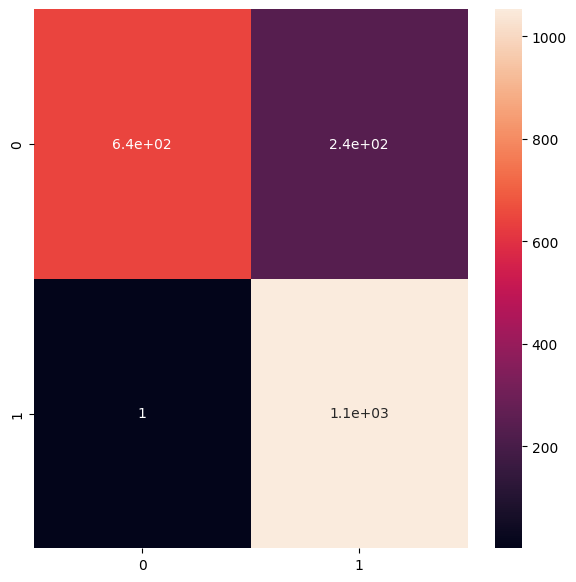

In [ ]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Testing accuracy remains the same
test_accuracy = accuracy_score(original, predict)  # Note: Using accuracy_score
print("Testing Accuracy:", test_accuracy)

# Classification report remains the same
report = classification_report(original, predict, labels=[0, 1])
print("Classification Report:\n", report)

Testing Accuracy: 0.8765495867768595
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.73      0.84       882
           1       0.82      1.00      0.90      1054

    accuracy                           0.88      1936
   macro avg       0.91      0.86      0.87      1936
weighted avg       0.90      0.88      0.87      1936



#BUILD A RESUNET SEGMENTATION MODEL

In [ ]:
#spliting the data into train and test data

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(defect_class_mask_df, test_size=0.2)

In [ ]:
#creating separate list for imageId, classId and rle to pass into the generator

train_ids = list(X_train.ImageId)
train_class = list(X_train.ClassId)
train_rle = list(X_train.EncodedPixels)

val_ids = list(X_val.ImageId)
val_class = list(X_val.ClassId)
val_rle = list(X_val.EncodedPixels)

In [ ]:
from utilities import DataGenerator

#creating image generators

training_generator = DataGenerator(train_ids,train_class, train_rle, train_dir)
validation_generator = DataGenerator(val_ids,val_class,val_rle, train_dir)


In [ ]:
def resblock(X, f):


  # making a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1), strides = (1,1), kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
from keras.layers import UpSampling2D, concatenate

def upsample_concat(x, skip):
  """
  This function upsamples the input tensor x and concatenates it with the skip connection tensor.
  """
  x = UpSampling2D((2,2))(x)
  merge = concatenate([x, skip], axis=3)
  return merge

input_shape = (256,256,1)

#Input tensor shape
X_input = Input(input_shape)

#Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

#Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

#Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

#Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

#Stage 5
conv5_in = resblock(pool_4, 256)

#Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

#Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

#Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

#Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

#Final Output
output = Conv2D(4, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )

#Loss function

In [ ]:
%cd /content/drive/My Drive/SM

from utilities import focal_tversky, tversky_loss, tversky

/content/drive/My Drive/SM


In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1) # Changed 'lr' to 'learning_rate'
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
# Changed the file extension to '.keras'
checkpointer = ModelCheckpoint(filepath="resunet-segmentation-weights.keras", verbose=1, save_best_only=True)

In [ ]:
# save the model for future use

model_json = model_seg.to_json()
with open("resunet-segmentation-model.json","w") as json_file:
  json_file.write(model_json)

#ASSESS TRAINED SEGMENTATION MODEL PERFORMANCE

In [ ]:
from utilities import focal_tversky, tversky_loss, tversky # Make sure this line is present

with open('resunet-segmentation-model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model with custom_objects
model_seg = tf.keras.models.model_from_json(json_savedModel, custom_objects={'focal_tversky': focal_tversky})

model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1) # Changed 'lr' to 'learning_rate' as it was defined in a previous code block.
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
# data containing test images for segmentation task
test_df = pd.read_csv('test.csv')


In [ ]:
test_df

,ImageId,ClassId,EncodedPixels
0,0ca915b9f.jpg,3,188383 3 188637 5 188892 6 189148 5 189403 6 1...
1,7773445b7.jpg,3,75789 33 76045 97 76300 135 76556 143 76811 15...
2,5e0744d4b.jpg,3,120323 91 120579 182 120835 181 121091 181 121...
3,6ccde604d.jpg,3,295905 32 296098 95 296290 159 296483 222 2967...
4,16aabaf79.jpg,1,352959 24 353211 28 353465 31 353719 33 353973...
...,...,...,...
633,a4334d7da.jpg,4,11829 7 12073 20 12317 32 12566 40 12821 41 13...
634,418e47222.jpg,3,46340 43 46596 127 46852 211 47108 253 47364 2...
635,817a545aa.jpg,3,206529 64 206657 4518 211201 179 211457 128 21...
636,caad490a5.jpg,3,59631 10 59867 30 60103 50 60339 69 60585 79 6...


In [ ]:
test_df.ImageId

,ImageId
0,0ca915b9f.jpg
1,7773445b7.jpg
2,5e0744d4b.jpg
3,6ccde604d.jpg
4,16aabaf79.jpg
...,...
633,a4334d7da.jpg
634,418e47222.jpg
635,817a545aa.jpg
636,caad490a5.jpg


In [ ]:
from utilities import prediction

# make prediction
image_id, defect_type, mask = prediction(test_df, model, model_seg)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━

In [ ]:
# create a dataframe for the result
df_pred= pd.DataFrame({'ImageId': image_id,'EncodedPixels': mask,'ClassId': defect_type})
df_pred.head()

NameError: name 'image_id' is not defined

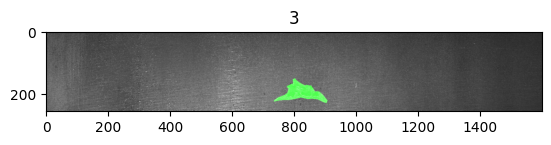

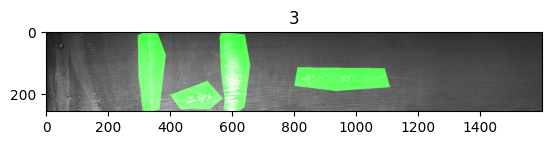

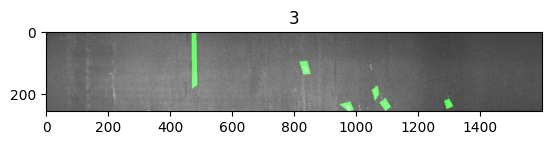

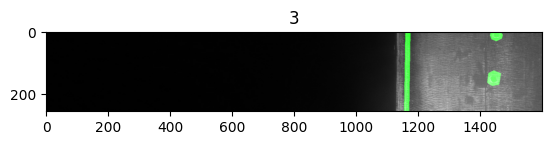

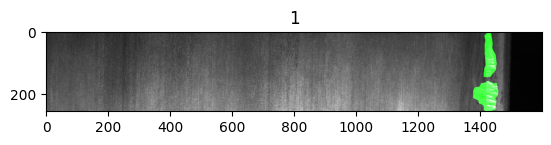

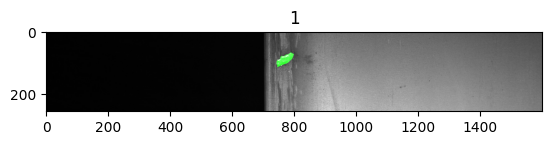

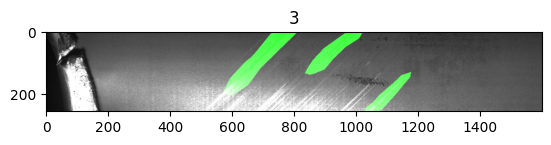

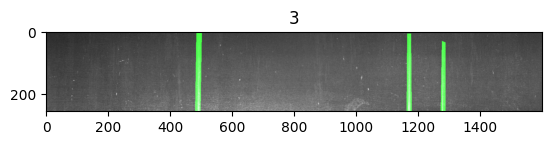

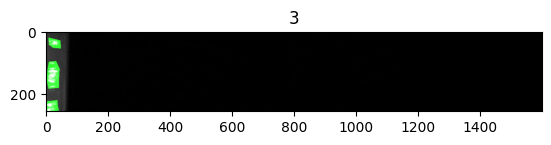

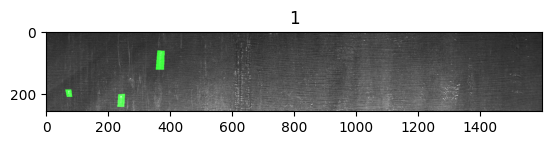

In [ ]:
# Let's show the images along with their original (ground truth) masks
for i in range(10):

  # read the images using opencv and convert them to rgb format
  img = io.imread(os.path.join(train_dir,test_df.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Obtain mask for the image from rle
  mask = rle2mask(test_df.EncodedPixels[i],img.shape[0],img.shape[1])

  img[mask == 1,1] = 255
  plt.figure()
  plt.title(test_df.ClassId[i])
  plt.imshow(img)

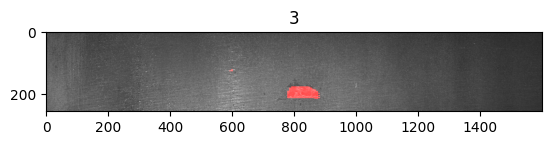

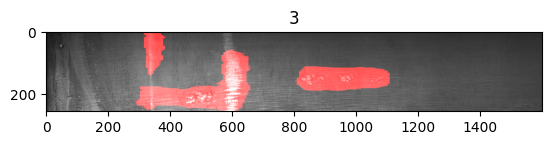

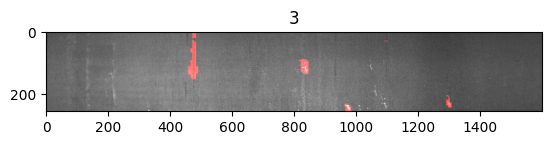

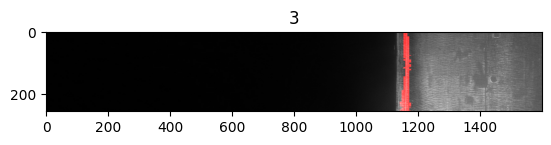

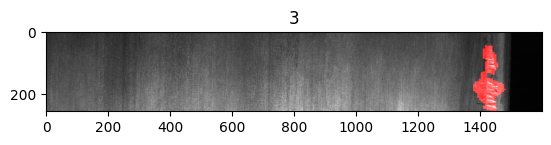

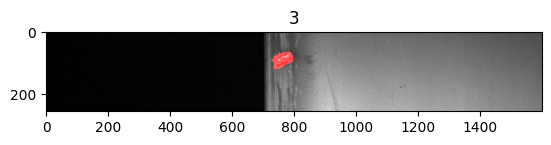

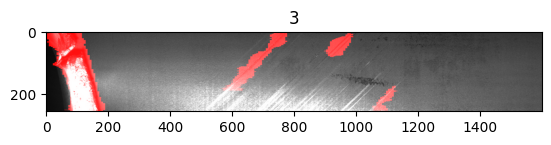

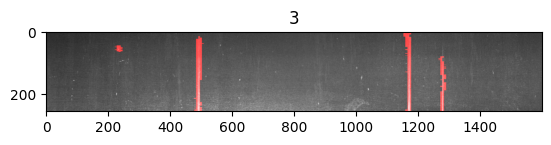

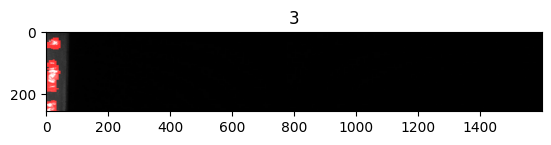

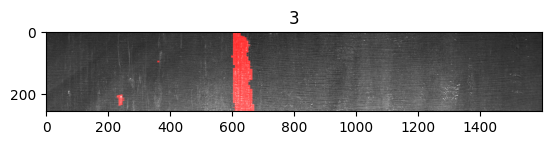

In [ ]:
# visualize the results (model predictions)

directory = "train_images"

for i in range(10):

  # read the images using opencv and convert to rgb format
  img = io.imread(os.path.join(directory,df_pred.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # get the mask for the image from rle
  mask = rle2mask(df_pred.EncodedPixels[i],img.shape[0],img.shape[1])

  img[mask == 1,0] = 255
  plt.figure()
  plt.title(df_pred.ClassId[i])
  plt.imshow(img)

In [ ]:
!pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.4 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
from keras import Model, callbacks
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras import backend as K

K.clear_session()

# Directory and Data loading
train_dir = os.path.join(os.path.expanduser("~"), r"/content/drive/My Drive/SM/")
all_images_df = pd.read_csv(os.path.join(train_dir, "defect_and_no_defect.csv"))

train, test = train_test_split(all_images_df, test_size=0.15)
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.15)
train['label'] = train['label'].astype(str)
train_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory=os.path.join(train_dir, 'train_images'),
    x_col="ImageID",
    y_col="label",
    subset="training",
    batch_size=16,
    shuffle=True,
    class_mode="categorical",
    target_size=(256, 256)
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory=os.path.join(train_dir, 'train_images'),
    x_col="ImageID",
    y_col="label",
    subset="validation",
    batch_size=16,
    shuffle=True,
    class_mode="categorical",
    target_size=(256, 256)
)

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=os.path.join(train_dir, 'train_images'),
    x_col="ImageID",
    y_col=None,
    batch_size=16,
    shuffle=False,
    class_mode=None,
    target_size=(256, 256)
)

# Residual Block
def residual_block(x, filters):
    res = x
    x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    res = layers.Conv2D(filters, (1, 1), padding='same')(res)
    x = layers.Add()([x, res])
    return x

# Downsampling Block
def downsample_block(x, filters):
    x = residual_block(x, filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

# Upsampling Block
def upsample_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding='same')(x)
    x = layers.Concatenate()([x, skip])
    x = residual_block(x, filters)
    return x

# ResUNet Model Architecture
inputs = layers.Input(shape=(256, 256, 3))

# Encoder
s1, p1 = downsample_block(inputs, 64)
s2, p2 = downsample_block(p1, 128)
s3, p3 = downsample_block(p2, 256)
s4, p4 = downsample_block(p3, 512)

# Bridge
b1 = residual_block(p4, 1024)

# Decoder
d1 = upsample_block(b1, s4, 512)
d2 = upsample_block(d1, s3, 256)
d3 = upsample_block(d2, s2, 128)
d4 = upsample_block(d3, s1, 64)

# Output
outputs = layers.GlobalAveragePooling2D()(d4)  # Global average pooling to reduce spatial dimensions
outputs = layers.Dense(2, activation='softmax')(outputs) # Output layer with 1 neuron and sigmoid activation

# Model creation
model = Model(inputs, outputs)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
checkpointer = callbacks.ModelCheckpoint(filepath="/content/drive/My Drive/SM/resunet_weights.keras", verbose=1, save_best_only=True)




Found 9390 validated image filenames belonging to 2 classes.
Found 1657 validated image filenames belonging to 2 classes.
Found 1950 validated image filenames.


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import callbacks


# Train the model
history = model.fit(
    train_generator,
    epochs=5,  # Adjust the number of epochs as needed
    validation_data=valid_generator,
    callbacks=[earlystopping, checkpointer]  # Include your callbacks
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy}")


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/587 ━━━━━━━━━━━━━━━━━━━━ 22:42:18 140s/step - accuracy: 0.6406 - loss: 0.7751

KeyboardInterrupt: 

In [ ]:
# save the trained model architecture for future use

model_json = history.to_json()
with open("resunet-segmentation-model.json","w") as json_file:
  json_file.write(model_json)

NameError: name 'model_json' is not defined

In [ ]:
def focal_tversky(y_true, y_pred):
    # ... (Your implementation of focal_tversky) ...
    pass # Replace pass with actual focal tversky logic
# Load the model with custom objects
with open('/content/drive/My Drive/SM/resunet-segmentation-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model
model = tf.keras.models.model_from_json(json_savedModel, custom_objects={'focal_tversky': focal_tversky})  # Pass custom_objects
model.load_weights('/content/drive/My Drive/SM/resunet-segmentation-weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics= ["accuracy"])

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming you have already defined your model and generators (train_generator, valid_generator, test_generator)

# Predict on the test set
predict = model.predict(test_generator)
predict = np.argmax(predict, axis=1) # Get predicted class labels

# Get the true labels from the test set
original = test['label'].astype(int).values # Assuming 'label' column in your test dataframe

# Generate and print the classification report
report = classification_report(original, predict, labels=[0, 1])
print("Classification Report:\n", report)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  9/122 ━━━━━━━━━━━━━━━━━━━━ 2:22 1s/step

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky)


In [ ]:
with open('/content/drive/My Drive/SM/resunet-segmentation-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('/content/drive/My Drive/SM/resunet-segmentation-weights.hdf5')
model.compile(loss = 'focal_tversky', optimizer='Nadam', metrics= ["accuracy"])

TypeError: Could not locate function 'focal_tversky'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'focal_tversky', 'registered_name': 'function'}

In [ ]:
# prompt: print classification report and testing accuracy for resunet model i build above

from sklearn.metrics import classification_report, accuracy_score

# Assuming 'predict' and 'original' are your model's predictions and true labels for the test set.

test_accuracy = accuracy_score(original, predict)
print("Testing Accuracy:", test_accuracy)

report = classification_report(original, predict, labels=[0, 1])
print("Classification Report:\n", report)

#Building CNN Model

In [ ]:
# prompt: # prompt: write code to train my model which i have made using ResNEt50 and ResUNet in above snippets, now build using CNN and also givr train_generator, valid geerator and test genrator

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import os
import pandas as pd
import numpy as np

# Directory and Data loading
train_dir = os.path.join(os.path.expanduser("~"), r"/content/drive/My Drive/SM/")
all_images_df = pd.read_csv(os.path.join(train_dir, "defect_and_no_defect.csv"))

train, test = train_test_split(all_images_df, test_size=0.15)
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.15)
train['label'] = train['label'].astype(str)
train_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory=os.path.join(train_dir, 'train_images'),
    x_col="ImageID",
    y_col="label",
    subset="training",
    batch_size=16,
    shuffle=True,
    class_mode="categorical",
    target_size=(256, 256)
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory=os.path.join(train_dir, 'train_images'),
    x_col="ImageID",
    y_col="label",
    subset="validation",
    batch_size=16,
    shuffle=True,
    class_mode="categorical",
    target_size=(256, 256)
)

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=os.path.join(train_dir, 'train_images'),
    x_col="ImageID",
    y_col="label",
    batch_size=16,
    shuffle=False,
    class_mode=None,
    target_size=(256, 256)
)

# CNN Model Architecture
def build_cnn_model(input_shape=(256, 256, 3)):
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))  # 2 output classes
    return model

# Build the CNN model
model = build_cnn_model()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
checkpointer = callbacks.ModelCheckpoint(filepath="/content/drive/My Drive/SM/cnn_weights.keras", verbose=1, save_best_only=True)



Found 9390 validated image filenames belonging to 2 classes.
Found 1657 validated image filenames belonging to 2 classes.
Found 1950 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 78/587 ━━━━━━━━━━━━━━━━━━━━ 1:07:56 8s/step - accuracy: 0.5444 - loss: 0.8681

KeyboardInterrupt: 

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=5,  # Adjust the number of epochs as needed
    validation_data=valid_generator,
    callbacks=[earlystopping, checkpointer]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy}")

In [ ]:
# Save the model
model_json = model.to_json()
with open("cnn_model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# Predict on the test set
predict = model.predict(test_generator)
predict = np.argmax(predict, axis=1)

# Get the true labels from the test set
original = test['label'].astype(int).values

# Generate and print the classification report
report = classification_report(original, predict, labels=[0, 1])
print("Classification Report:\n", report)


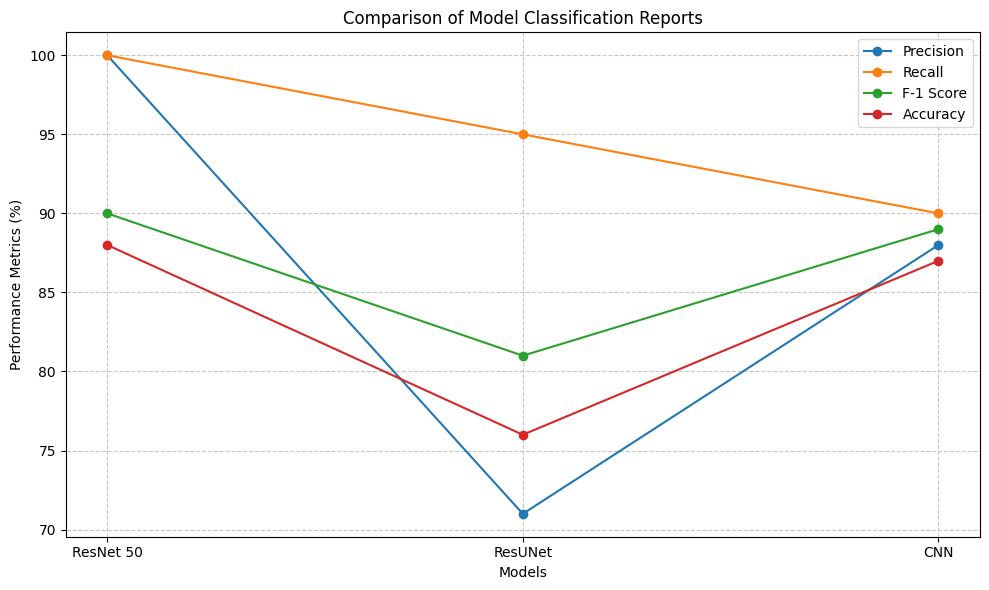

In [ ]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np

# Data for the models
models = ['ResNet 50', 'ResUNet', 'CNN']
precision = [100, 71, 88]
recall = [100, 95, 90]
f1_score = [90, 81, 89]
accuracy = [88, 76, 87]

# X-axis positions for the models
x = np.arange(len(models))

# Create the line plot
plt.figure(figsize=(10, 6))

plt.plot(x, precision, label='Precision', marker='o')
plt.plot(x, recall, label='Recall', marker='o')
plt.plot(x, f1_score, label='F-1 Score', marker='o')
plt.plot(x, accuracy, label='Accuracy', marker='o')

# Add labels, title, and legend
plt.xticks(x, models)  # Add model names as x-axis labels
plt.xlabel('Models')
plt.ylabel('Performance Metrics (%)')
plt.title('Comparison of Model Classification Reports')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


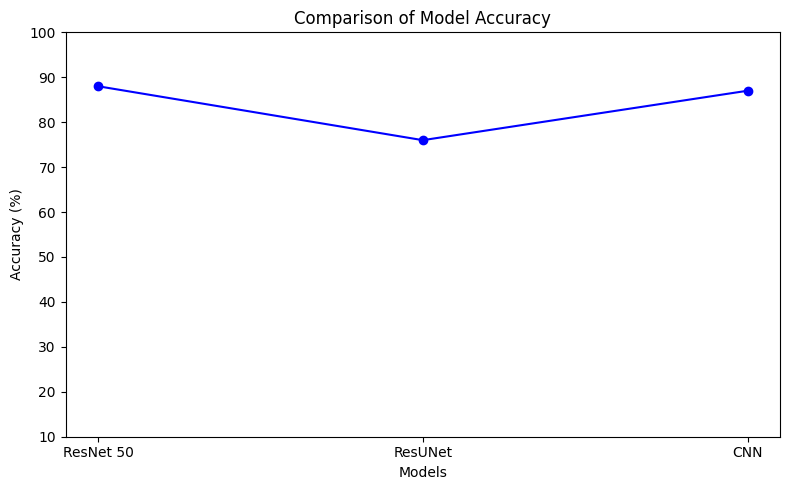

In [ ]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np

# Data for the models
models = ['ResNet 50', 'ResUNet', 'CNN']
accuracy = [88, 76, 87]

# X-axis positions for the models
x = np.arange(len(models))

# Create the line plot
plt.figure(figsize=(8, 5))

plt.plot(x, accuracy, label='Accuracy', marker='o', color='blue')

# Add labels, title, and legend
plt.xticks(x, models)  # Add model names as x-axis labels
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Model Accuracy')

# Customize y-axis limits and ticks
plt.ylim(10, 100)  # Set y-axis range starting from 10
plt.yticks(np.arange(10, 101, 10))  # Set y-axis ticks with intervals of 10

# Display the plot without grid lines
plt.tight_layout()
plt.show()
